######################################################################

<span style="font-size:30pt;font-family:Advent">Carbon Metalenses - Ultimate - Rerun </span>
######################################################################

In [13]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import os, uuid
# import subprocess
import pickle, time, sys
sys.path.append(os.getcwd())
from matplotlib.colors import LogNorm
%reload_ext autoreload
%autoreload 2
from metalens import *
import datetime
from tabulate import tabulate

## Finite Conjugate 1 to 1: 0.1 NA, 250 nm pitch, p polarization

### S4

In [14]:
simulation_parameters = {
                        'wavelength': 0.532,
                        'post_width': 0.075,
                        'post_height': 0.600,
                        'cell_width': 0.25,
                        'epsilon': 5.8418,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 0, 'p_amp': 1,
                        'finite_conjugate': True,
                        'w': 0.,
                        }
simulation_parameters = expand_sim_params(simulation_parameters)

In [15]:
results = post_phase(simulation_parameters)

In [16]:
post_widths = np.linspace(0.05,0.2,20)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Exi, Exr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

0.1942106818771636


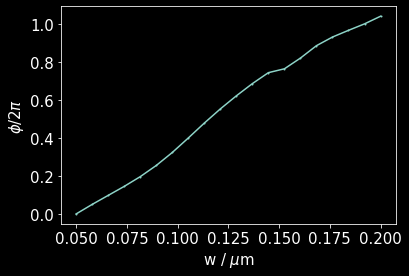

In [17]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [18]:
pickle.dump({'post_widths':post_widths,'phases': phases, 'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

### MEEP - run

In [46]:
sim_fname =  '/Users/juan/ZiaLab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [47]:
metalens_params = {'post_height':simulation_parameters['post_height'],
                  'NA':0.5,
                  'polarization': 'p',
                  'aperture': 100,
                  'sub_thickness': 5,
                  'air_space': 100,
                  'unit cell size': simulation_parameters['cell_width'],
                  'epsilon': simulation_parameters['epsilon'],
                  'phases': phases,
                  'widths': post_widths,
                  'wavelength': simulation_parameters['wavelength'],
                  'min_width': 0.05,
                  'pml width': 1,
                  'resolution': 20.,
                  'sim_id': simulation_parameters['sim_id'],
                  'simulation_parameters' : simulation_parameters,
                  'complex_fields' : False,
                  'axial_offset': 0}

metalens_params = aux_params(metalens_params)

metalens_params, geometry = make_metalens_geometry(metalens_params)

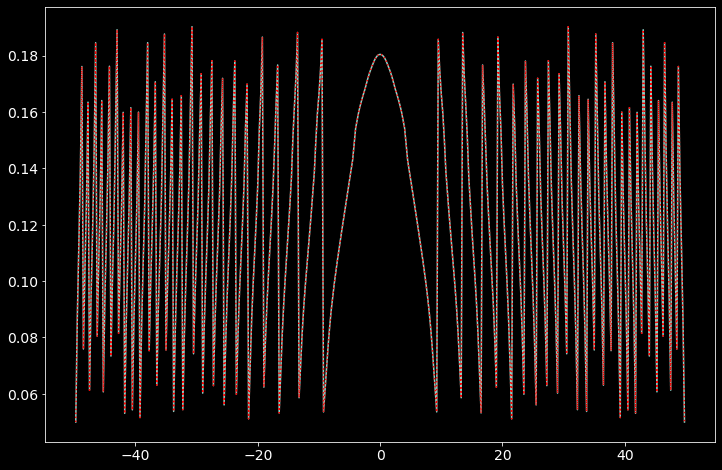

In [48]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12,8))
plt.plot(metalens_params['axis_positions'],metalens_params['required_widths'])
plt.plot(metalens_params['axis_positions'],metalens_params['required_widths'],'r:')
plt.show()

In [49]:
metal = metalens(metalens_params)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00212979 s
Working in 2D dimensions.
Computational cell is 100 x 105.6 x 0 with resolution 20
     block, center = (0,-50.3,0)
          size (100,5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.8418,5.8418,5.8418)
     block, center = (-49.75,-47.5,0)
          size (0.05,0.6,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.8418,5.8418,5.8418)
     block, center = (-49.5,-47.5,0)
          size (0.0866431,0.6,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.8418,5.8418,5.8418)
     block, center = (-49.25,-47.5,0)
          size (0.112024,0.6,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.8418,5.8418,5.8418)
     block, center = (-49,-47.5,0)
          size (0.138632,0.6,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          

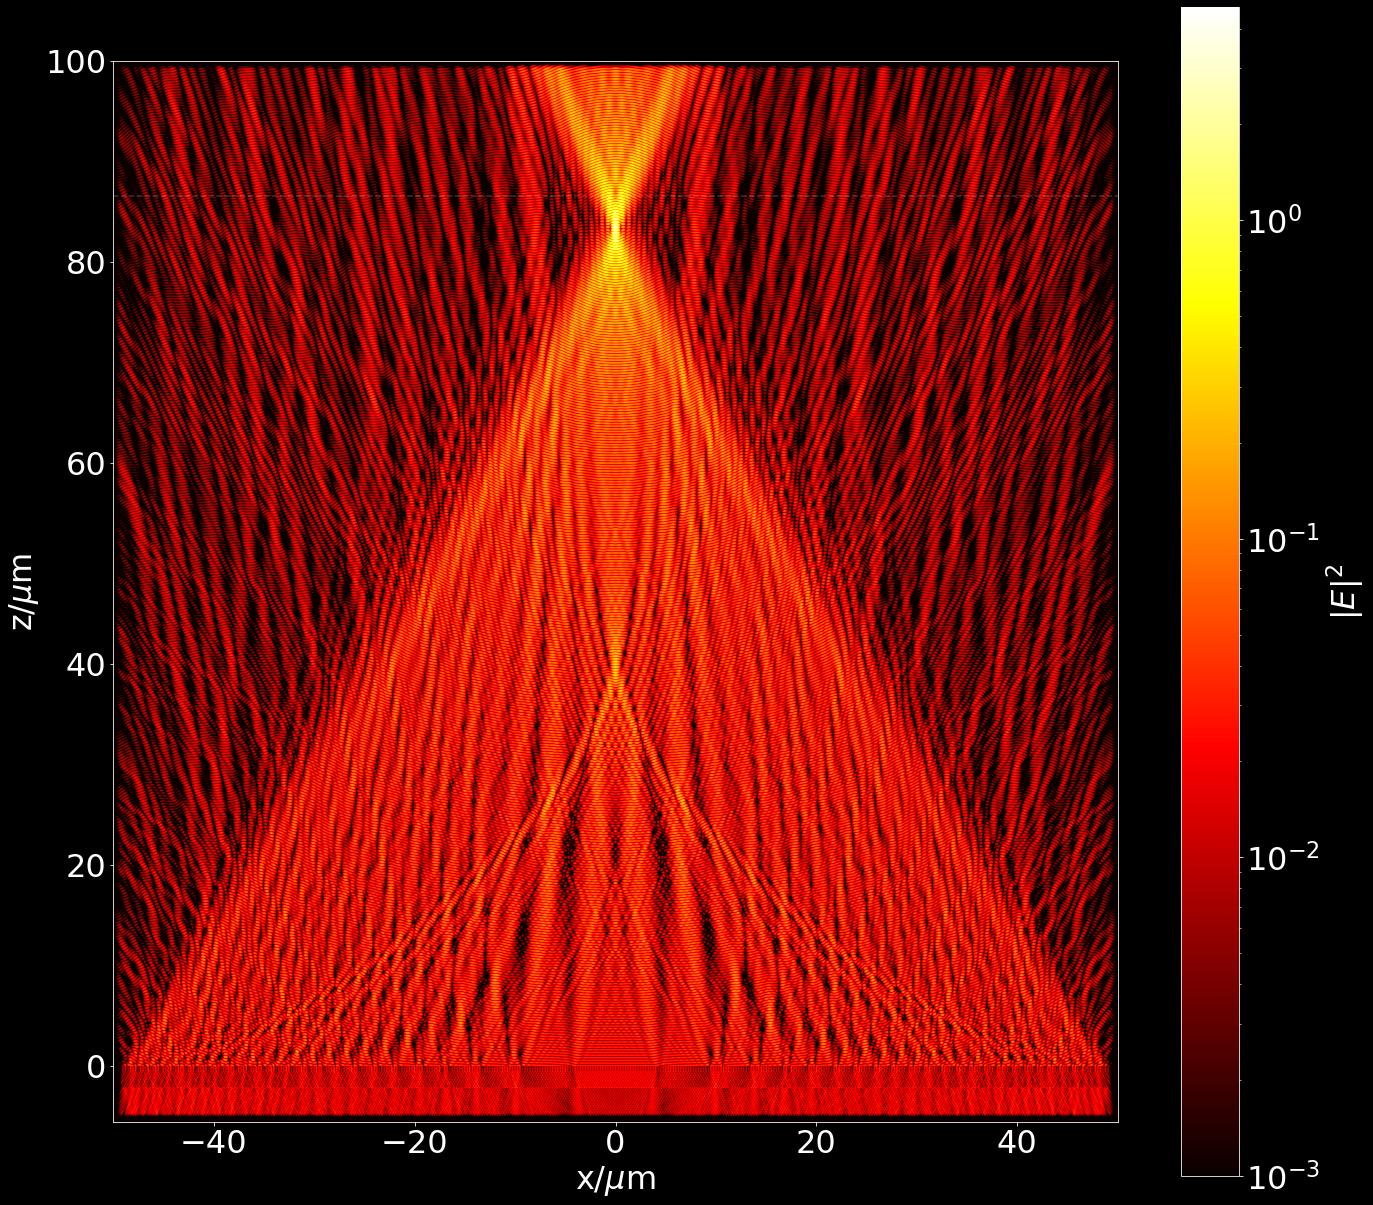

In [45]:
extent = [-metal['aperture']/2,
          metal['aperture']/2,
          -metal['H']/2-metal['top_of_posts_coordinate'],
          metal['H']/2-metal['top_of_posts_coordinate']]
ez = metal['fields']['Ez']
e2 = np.abs(ez)**2
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(20,18))
plt.imshow(1/2*np.abs(ez)**2,extent=extent,
          cmap = 'hot',
          origin='lower',
          norm=LogNorm(vmin=0.001))
plt.xlabel('x/$\mu$m')
plt.ylabel('z/$\mu$m')
plt.plot([-metal['aperture']/2,metal['aperture']/2],
        [metal['f']]*2,'w--',alpha=0.2)
plt.colorbar(label='$|E|^2$')
plt.tight_layout()
plt.show()